# Imports

In [1]:
import numpy as np
import pandas as pd

import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint

# 주가 데이터

In [3]:
# 주가 URL
stock_url = 'https://github.com/KyoungmiKwon/Bigdata_Training_at_ITwill/raw/main/Team_Project/B05_KM_StockPrice_for_regression.xlsx'

In [4]:
# 주가 데이터 불러오기
samsung_stock = pd.read_excel(stock_url, sheet_name='005930', header=0)
lg_stock = pd.read_excel(stock_url, sheet_name='066570', header=0)
yg_stock = pd.read_excel(stock_url, sheet_name='122870', header=0)
jyp_stock = pd.read_excel(stock_url, sheet_name='035900', header=0)

# 삼성

In [ ]:
samsung_stock[:3]

,Date,Open,High,Low,Close,Volume,Change,Volume_Change,Sentiment
0,1997-05-03,1090,1093,1077,1087,67197,0.00000,67197,0
1,1997-05-06,1086,1093,1081,1092,93290,0.00460,26093,1
2,1997-05-07,1084,1088,1077,1085,67110,-0.00641,-26180,-1


In [5]:
def make_dataset(data, label, window_size=20):  #> 데이터 셋 window_size 수 만큼의 일주가 데이터로 예측 하기위해 dataset 나눔.
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))   # 예측하고자 하는 날의 전날부터 20일전까지의 주가 데이터
        label_list.append(np.array(label.iloc[i+window_size]))      # 예측하고자 하는 날의 label(Close:종가) 데이터
    return np.array(feature_list), np.array(label_list)

## 정규화

In [6]:
# 역 minmax 스케일링
# 정규화된 종가 데이터 -> 원래 종가
def reverse_min_max_scaling(org_x, x): 
    org_x_np = np.asarray(org_x)
    x_np = np.asarray(x)
    return (x_np * (org_x_np.max() - org_x_np.min() + 1e-7)) + org_x_np.min()

In [ ]:
scaler = MinMaxScaler()

scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'Volume_Change'] # [시가, 고가, 저가, 종가, 거래량, 거래량 변화량]
scaled_data = scaler.fit_transform(samsung_stock[scale_cols])
scaled_data = pd.DataFrame(scaled_data)
scaled_data.columns = scale_cols
samsung_scaled = pd.concat([samsung_stock['Date'], scaled_data, samsung_stock['Sentiment']],axis=1)

In [ ]:
samsung_scaled[-3:]

,Date,Open,High,Low,Close,Volume,Volume_Change,Sentiment
5996,2021-04-26,0.918051,0.862603,0.922905,0.917011,0.171527,0.515139,1
5997,2021-04-27,0.921373,0.860537,0.921788,0.910371,0.143307,0.512643,-1
5998,2021-04-28,0.921373,0.859504,0.917318,0.901519,0.172710,0.568329,-1


## LSTM total stock data  / feature (거래량 or 거래량 변화량 or 거래량+거래량+변화량)

In [ ]:
TEST_SIZE = 300    # 최근 300일간의 주가를 예측하겠다
WINDOW_SIZE = 30   # 30일의 데이터를 기반으로 다음날 주가를 예측하겠다

train = samsung_scaled[:-TEST_SIZE]     
test = samsung_scaled[-TEST_SIZE:]      # 최근 300일간의 데이터 -> test 데이터

In [ ]:
feature_cols_4_v = ['Open', 'High', 'Low', 'Volume']                     # 특성 값 4개
feature_cols_4_vc = ['Open', 'High', 'Low', 'Volume_Change']
feature_cols_5 = ['Open', 'High', 'Low', 'Volume', 'Volume_Change']    # 특성 값 5개
label_cols = ['Close']  # label 데이터(종가)

train_feature_4_v = train[feature_cols_4_v]
train_feature_4_vc = train[feature_cols_4_vc]
train_feature_5 = train[feature_cols_5]
train_label = train[label_cols]

# train dataset 생성
train_feature_4_v, train_label_4_v = make_dataset(train_feature_4_v, train_label, WINDOW_SIZE)
train_feature_4_vc, train_label_4_vc = make_dataset(train_feature_4_vc, train_label, WINDOW_SIZE)
train_feature_5, train_label_5 = make_dataset(train_feature_5, train_label, WINDOW_SIZE)

# train, validation set 생성
x_train_4_v, x_valid_4_v, y_train_4_v, y_valid_4_v = train_test_split(train_feature_4_v, train_label_4_v, test_size=0.2)
x_train_4_vc, x_valid_4_vc, y_train_4_vc, y_valid_4_vc = train_test_split(train_feature_4_vc, train_label_4_vc, test_size=0.2)
x_train_5, x_valid_5, y_train_5, y_valid_5 = train_test_split(train_feature_5, train_label_5, test_size=0.2)

# test dataset (실제 예측 해볼 데이터)
test_feature_4_v = test[feature_cols_4_v]
test_feature_4_vc = test[feature_cols_4_vc]
test_feature_5 = test[feature_cols_5]
test_label = test[label_cols]

test_feature_4_v, test_label_4_v = make_dataset(test_feature_4_v, test_label, WINDOW_SIZE)
test_feature_4_vc, test_label_4_vc = make_dataset(test_feature_4_vc, test_label, WINDOW_SIZE)
test_feature_5, test_label_5 = make_dataset(test_feature_5, test_label, WINDOW_SIZE)

In [ ]:
# 특성 4개_volume 모델 생성
model_4_v = Sequential()
model_4_v.add(LSTM(32, input_shape=(train_feature_4_v.shape[1], train_feature_4_v.shape[2]), activation='relu', return_sequences=False))
model_4_v.add(Dense(1))
model_4_v.compile(optimizer='adam', loss='mean_squared_error')  # 손실함수 = mse

# 조기종료
early_stop = EarlyStopping(monitor='val_loss', patience=5)  # 5번 연속 개선이 없으면 조기종료

# best 모델 저장
checkpoint = ModelCheckpoint('samsung_model_4_v.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history_4_v = model_4_v.fit(x_train_4_v, y_train_4_v, epochs=200, batch_size=16, validation_data=(x_valid_4_v, y_valid_4_v), 
                    callbacks=[early_stop, checkpoint])

Epoch 1/200
284/284 [==============================] - 5s 12ms/step - loss: 0.0146 - val_loss: 1.5635e-04

Epoch 00001: val_loss improved from inf to 0.00016, saving model to samsung_model_4_v.h5
Epoch 2/200
284/284 [==============================] - 3s 11ms/step - loss: 1.0978e-04 - val_loss: 1.0007e-04

Epoch 00002: val_loss improved from 0.00016 to 0.00010, saving model to samsung_model_4_v.h5
Epoch 3/200
284/284 [==============================] - 3s 12ms/step - loss: 8.4225e-05 - val_loss: 9.0208e-05

Epoch 00003: val_loss improved from 0.00010 to 0.00009, saving model to samsung_model_4_v.h5
Epoch 4/200
284/284 [==============================] - 3s 12ms/step - loss: 7.7103e-05 - val_loss: 8.7832e-05

Epoch 00004: val_loss improved from 0.00009 to 0.00009, saving model to samsung_model_4_v.h5
Epoch 5/200
284/284 [==============================] - 3s 11ms/step - loss: 6.9560e-05 - val_loss: 8.5944e-05

Epoch 00005: val_loss improved from 0.00009 to 0.00009, saving model to samsung_m

In [ ]:
# 주가 예측치 (300-30) 일치
predicted_stock_4_v = model_4_v.predict(test_feature_4_v)

In [ ]:
# 특성 4개_volumechange 모델 생성
model_4_vc = Sequential()
model_4_vc.add(LSTM(32, input_shape=(train_feature_4_vc.shape[1], train_feature_4_vc.shape[2]), activation='relu', return_sequences=False))
model_4_vc.add(Dense(1))
model_4_vc.compile(optimizer='adam', loss='mean_squared_error')  # 손실함수 = mse

# 조기종료
early_stop = EarlyStopping(monitor='val_loss', patience=5)  # 5번 연속 개선이 없으면 조기종료

# best 모델 저장
checkpoint = ModelCheckpoint('samsung_model_4_vc.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history_4_vc = model_4_vc.fit(x_train_4_vc, y_train_4_vc, epochs=200, batch_size=16, validation_data=(x_valid_4_vc, y_valid_4_vc), 
                    callbacks=[early_stop, checkpoint])

Epoch 1/200
284/284 [==============================] - 5s 12ms/step - loss: 0.0018 - val_loss: 1.1728e-04

Epoch 00001: val_loss improved from inf to 0.00012, saving model to samsung_model_4_vc.h5
Epoch 2/200
284/284 [==============================] - 3s 12ms/step - loss: 1.3218e-04 - val_loss: 1.0040e-04

Epoch 00002: val_loss improved from 0.00012 to 0.00010, saving model to samsung_model_4_vc.h5
Epoch 3/200
284/284 [==============================] - 3s 11ms/step - loss: 1.0328e-04 - val_loss: 9.8880e-05

Epoch 00003: val_loss improved from 0.00010 to 0.00010, saving model to samsung_model_4_vc.h5
Epoch 4/200
284/284 [==============================] - 3s 12ms/step - loss: 8.9325e-05 - val_loss: 9.7063e-05

Epoch 00004: val_loss improved from 0.00010 to 0.00010, saving model to samsung_model_4_vc.h5
Epoch 5/200
284/284 [==============================] - 3s 11ms/step - loss: 1.0143e-04 - val_loss: 1.0424e-04

Epoch 00005: val_loss did not improve from 0.00010
Epoch 6/200
284/284 [=====

In [ ]:
# 주가 예측치 (300-30) 일치
predicted_stock_4_vc = model_4_vc.predict(test_feature_4_vc)

In [ ]:
# 특성 5개 모델 생성
model_5 = Sequential()
model_5.add(LSTM(32, input_shape=(train_feature_5.shape[1], train_feature_5.shape[2]), activation='relu', return_sequences=False))
model_5.add(Dense(1))
model_5.compile(optimizer='adam', loss='mean_squared_error')  # 손실함수 = mse

# 조기종료
early_stop = EarlyStopping(monitor='val_loss', patience=5)  # 5번 연속 개선이 없으면 조기종료

# best 모델 저장
checkpoint = ModelCheckpoint('samsung_model_5.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history_5 = model_5.fit(x_train_5, y_train_5, epochs=200, batch_size=16, validation_data=(x_valid_5, y_valid_5), 
                    callbacks=[early_stop, checkpoint])

Epoch 1/200
284/284 [==============================] - 5s 12ms/step - loss: 0.0072 - val_loss: 1.1310e-04

Epoch 00001: val_loss improved from inf to 0.00011, saving model to samsung_model_5.h5
Epoch 2/200
284/284 [==============================] - 3s 11ms/step - loss: 1.3396e-04 - val_loss: 1.0084e-04

Epoch 00002: val_loss improved from 0.00011 to 0.00010, saving model to samsung_model_5.h5
Epoch 3/200
284/284 [==============================] - 3s 11ms/step - loss: 8.6179e-05 - val_loss: 1.2964e-04

Epoch 00003: val_loss did not improve from 0.00010
Epoch 4/200
284/284 [==============================] - 3s 11ms/step - loss: 8.8214e-05 - val_loss: 1.0015e-04

Epoch 00004: val_loss improved from 0.00010 to 0.00010, saving model to samsung_model_5.h5
Epoch 5/200
284/284 [==============================] - 3s 11ms/step - loss: 9.5319e-05 - val_loss: 9.9685e-05

Epoch 00005: val_loss improved from 0.00010 to 0.00010, saving model to samsung_model_5.h5
Epoch 6/200
284/284 [=================

In [ ]:
# 특성 5가지를 가지고 예측한 주가 170일치 = (test_size - window_size)
predicted_stock_5 = model_5.predict(test_feature_5)

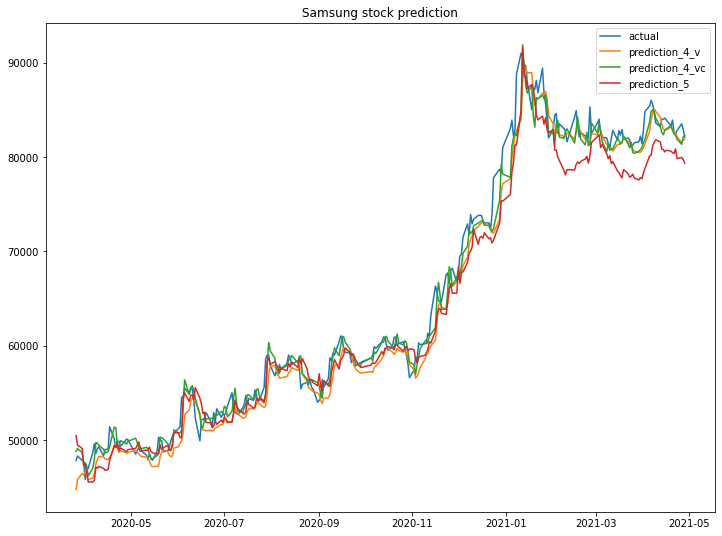

In [ ]:
time_list = test.Date[-(TEST_SIZE-WINDOW_SIZE):]

plt.figure(figsize=(12, 9))
plt.title('Samsung stock prediction')

plt.plot(time_list, reverse_min_max_scaling(samsung_stock['Close'], test_label_5), label = 'actual')
plt.plot(time_list, reverse_min_max_scaling(samsung_stock['Close'], predicted_stock_4_v), label = 'prediction_4_v')
plt.plot(time_list, reverse_min_max_scaling(samsung_stock['Close'], predicted_stock_4_vc), label = 'prediction_4_vc')
plt.plot(time_list, reverse_min_max_scaling(samsung_stock['Close'], predicted_stock_5), label = 'prediction_5')

plt.legend()
plt.show()

In [ ]:
# 특성을 4가지(Volume)로 한 모델 평가 -> loss = mse = 0.0002233 / 0.0004136
model_4_v.evaluate(test_feature_4_v, test_label_4_v)

9/9 [==============================] - 0s 3ms/step - loss: 4.1362e-04


0.0004136232892051339

In [ ]:
# 특성을 4가지(VolumeChange)로 한 모델 평가 -> loss = mse = 0.0002396 / 0.0002634
model_4_vc.evaluate(test_feature_4_vc, test_label_4_vc)

9/9 [==============================] - 0s 4ms/step - loss: 2.6342e-04


0.00026341708144173026

In [ ]:
# 특성을 5가지(Volume, VolumeChange)로 한 모델 평가 -> loss = mse = 0.0002487 / 0.0007295
model_5.evaluate(test_feature_5, test_label_5)

9/9 [==============================] - 0s 4ms/step - loss: 7.2951e-04


0.0007295084651559591

## LSTM total stock data  / feature (감성 or 거래량+감성 or 거래량변화량+감성)

In [ ]:
feature_cols_4_s = ['Open', 'High', 'Low', 'Sentiment']
feature_cols_5_vs = ['Open', 'High', 'Low', 'Volume', 'Sentiment']    # 특성 값 5개
feature_cols_5_vcs = ['Open', 'High', 'Low', 'Volume_Change', 'Sentiment']    # 특성 값 5개
label_cols = ['Close']  # label 데이터(종가)

train_feature_4_s = train[feature_cols_4_s]
train_feature_5_vs = train[feature_cols_5_vs]
train_feature_5_vcs = train[feature_cols_5_vcs]
train_label = train[label_cols]

# train dataset 생성
train_feature_4_s, train_label_4_s = make_dataset(train_feature_4_s, train_label, WINDOW_SIZE)
train_feature_5_vs, train_label_5_vs = make_dataset(train_feature_5_vs, train_label, WINDOW_SIZE)
train_feature_5_vcs, train_label_5_vcs = make_dataset(train_feature_5_vcs, train_label, WINDOW_SIZE)

# train, validation set 생성
x_train_4_s, x_valid_4_s, y_train_4_s, y_valid_4_s = train_test_split(train_feature_4_s, train_label_4_s, test_size=0.2)
x_train_5_vs, x_valid_5_vs, y_train_5_vs, y_valid_5_vs = train_test_split(train_feature_5_vs, train_label_5_vs, test_size=0.2)
x_train_5_vcs, x_valid_5_vcs, y_train_5_vcs, y_valid_5_vcs = train_test_split(train_feature_5_vcs, train_label_5_vcs, test_size=0.2)

# test dataset (실제 예측 해볼 데이터)
test_feature_4_s = test[feature_cols_4_s]
test_feature_5_vs = test[feature_cols_5_vs]
test_feature_5_vcs = test[feature_cols_5_vcs]
test_label = test[label_cols]

test_feature_4_s, test_label_4_s = make_dataset(test_feature_4_s, test_label, WINDOW_SIZE)
test_feature_5_vs, test_label_5_vs = make_dataset(test_feature_5_vs, test_label, WINDOW_SIZE)
test_feature_5_vcs, test_label_5_vcs = make_dataset(test_feature_5_vcs, test_label, WINDOW_SIZE)

In [ ]:
# 특성 4개_Sentiment 모델 생성
model_4_s = Sequential()
model_4_s.add(LSTM(32, input_shape=(train_feature_4_s.shape[1], train_feature_4_s.shape[2]), activation='relu', return_sequences=False))
model_4_s.add(Dense(1))
model_4_s.compile(optimizer='adam', loss='mean_squared_error')  # 손실함수 = mse

# 조기종료
early_stop = EarlyStopping(monitor='val_loss', patience=5)  # 5번 연속 개선이 없으면 조기종료

# best 모델 저장
checkpoint = ModelCheckpoint('samsung_model_4_s.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history_4_s = model_4_s.fit(x_train_4_s, y_train_4_s, epochs=200, batch_size=16, validation_data=(x_valid_4_s, y_valid_4_s), 
                    callbacks=[early_stop, checkpoint])

In [ ]:
# 주가 예측치 (300-30) 일치
predicted_stock_4_s = model_4_s.predict(test_feature_4_s)

In [ ]:
# 특성 5개 모델 생성
model_5_vs = Sequential()
model_5_vs.add(LSTM(32, input_shape=(train_feature_5_vs.shape[1], train_feature_5_vs.shape[2]), activation='relu', return_sequences=False))
model_5_vs.add(Dense(1))
model_5_vs.compile(optimizer='adam', loss='mean_squared_error')  # 손실함수 = mse

# 조기종료
early_stop = EarlyStopping(monitor='val_loss', patience=5)  # 5번 연속 개선이 없으면 조기종료

# best 모델 저장
checkpoint = ModelCheckpoint('samsung_model_5_vs.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history_5_vs = model_5_vs.fit(x_train_5_vs, y_train_5_vs, epochs=200, batch_size=16, validation_data=(x_valid_5_vs, y_valid_5_vs), 
                    callbacks=[early_stop, checkpoint])

In [ ]:
# 주가 예측치 (300-30) 일치
predicted_stock_5_vs = model_5_vs.predict(test_feature_5_vs)

In [ ]:
# 특성 5개 모델 생성
model_5_vcs = Sequential()
model_5_vcs.add(LSTM(32, input_shape=(train_feature_5_vcs.shape[1], train_feature_5_vcs.shape[2]), activation='relu', return_sequences=False))
model_5_vcs.add(Dense(1))
model_5_vcs.compile(optimizer='adam', loss='mean_squared_error')  # 손실함수 = mse

# 조기종료
early_stop = EarlyStopping(monitor='val_loss', patience=5)  # 5번 연속 개선이 없으면 조기종료

# best 모델 저장
checkpoint = ModelCheckpoint('samsung_model_5_vcs.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history_5_vcs = model_5_vcs.fit(x_train_5_vcs, y_train_5_vcs, epochs=200, batch_size=16, validation_data=(x_valid_5_vcs, y_valid_5_vcs), 
                    callbacks=[early_stop, checkpoint])

In [ ]:
# 주가 예측치 (300-30) 일치
predicted_stock_5_vcs = model_5_vcs.predict(test_feature_5_vcs)

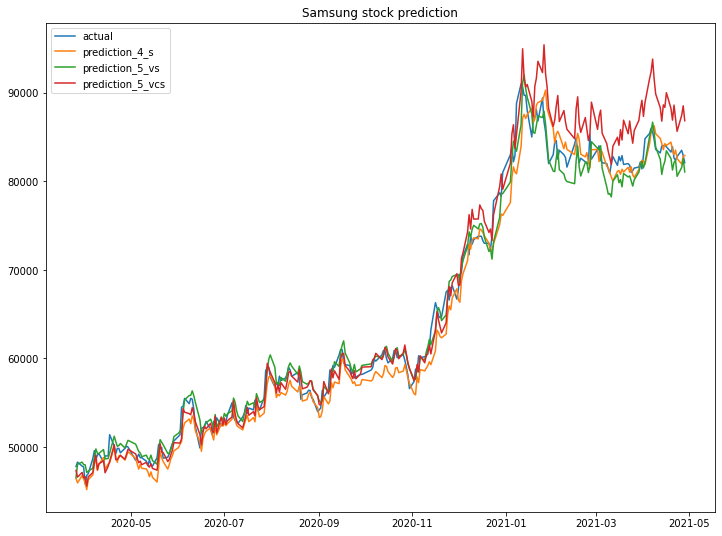

In [ ]:
time_list = test.Date[-(TEST_SIZE-WINDOW_SIZE):]
plt.figure(figsize=(12, 9))
plt.title('Samsung stock prediction')
plt.plot(time_list, reverse_min_max_scaling(samsung_stock['Close'], test_label_5), label = 'actual')
plt.plot(time_list, reverse_min_max_scaling(samsung_stock['Close'], predicted_stock_4_s), label = 'prediction_4_s')
plt.plot(time_list, reverse_min_max_scaling(samsung_stock['Close'], predicted_stock_5_vs), label = 'prediction_5_vs')
plt.plot(time_list, reverse_min_max_scaling(samsung_stock['Close'], predicted_stock_5_vcs), label = 'prediction_5_vcs')
plt.legend()
plt.show()

In [ ]:
# 특성을 4가지(Sentiment)로 한 모델 평가 -> loss = mse = 0.0004306
model_4_s.evaluate(test_feature_4_s, test_label_4_s)

9/9 [==============================] - 0s 5ms/step - loss: 4.3061e-04


0.0004306072660256177

In [ ]:
# 특성을 5가지(Volume, Sentiment)로 한 모델 평가 -> loss = mse = 0.0002742
model_5_vs.evaluate(test_feature_5_vs, test_label_5_vs)

9/9 [==============================] - 0s 4ms/step - loss: 2.7424e-04


0.000274243182502687

In [ ]:
# 특성을 5가지(VolumeChange, Sentiment)로 한 모델 평가 -> loss = mse = 0.0008638
model_5_vcs.evaluate(test_feature_5_vcs, test_label_5_vcs)

9/9 [==============================] - 0s 4ms/step - loss: 8.6382e-04


0.0008638194412924349

# LG

## 정규화

In [ ]:
scaler = MinMaxScaler()

scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'Volume_Change'] # [시가, 고가, 저가, 종가, 거래량, 거래량 변화량]
scaled_data = scaler.fit_transform(lg_stock[scale_cols])
scaled_data = pd.DataFrame(scaled_data)
scaled_data.columns = scale_cols
lg_scaled = pd.concat([lg_stock['Date'], scaled_data, lg_stock['Sentiment']],axis=1)

## LSTM stock data /  5 feature (Volume, Sentiment)

In [ ]:
lg_scaled[:3]

,Date,Open,High,Low,Close,Volume,Volume_Change,Sentiment
0,2002-04-22,0.168839,0.207920,0.185347,0.217167,0.364920,0.752039,0
1,2002-04-23,0.202603,0.192942,0.196439,0.182074,0.237844,0.389618,-2
2,2002-04-24,0.186037,0.180961,0.169026,0.170793,0.204549,0.457405,-2


In [ ]:
TEST_SIZE = 300    # 최근 20일간의 주가를 예측하겠다
WINDOW_SIZE = 30   # 5일의 데이터를 기반으로 다음날 주가를 예측하겠다

train = lg_scaled[:-TEST_SIZE]     
test = lg_scaled[-TEST_SIZE:]      # 최근 20일간의 데이터 -> test 데이터

In [ ]:
feature_cols_5 = ['Open', 'High', 'Low', 'Volume', 'Sentiment']    # 특성 값 5개
label_cols = ['Close']  # label 데이터(종가)

train_feature_5 = train[feature_cols_5]
train_label = train[label_cols]

# train dataset 생성
train_feature_5, train_label_5 = make_dataset(train_feature_5, train_label, WINDOW_SIZE)

# train, validation set 생성
x_train_5, x_valid_5, y_train_5, y_valid_5 = train_test_split(train_feature_5, train_label_5, test_size=0.2)

# test dataset (실제 예측 해볼 데이터)
test_feature_5 = test[feature_cols_5]
test_label = test[label_cols]

test_feature_5, test_label_5 = make_dataset(test_feature_5, test_label, WINDOW_SIZE)

In [ ]:
model_5_t_hs = Sequential()
model_5_t_hs.add(LSTM(32, input_shape=(train_feature_5.shape[1], train_feature_5.shape[2]), activation='tanh', recurrent_activation='hard_sigmoid', return_sequences=False, kernel_initializer='he_normal' ))
model_5_t_hs.add(Dense(1))
model_5_t_hs.compile(optimizer='adam', loss='mean_squared_error')  # 손실함수 = mse

# 조기종료
early_stop = EarlyStopping(monitor='val_loss', patience=5)  # 5번 연속 개선이 없으면 조기종료

# best 모델 저장
checkpoint = ModelCheckpoint('lg_5_t_hs.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history_5_t_hs = model_5_t_hs.fit(x_train_5, y_train_5, epochs=200, batch_size=16, validation_data=(x_valid_5, y_valid_5), 
                    callbacks=[early_stop, checkpoint])

In [ ]:
# tanh 함수, hardsigmoid 함수를 쓰는 모델
predicted_stock_5_t_hs = model_5_t_hs.predict(test_feature_5)

In [ ]:
model_5_re = Sequential()
model_5_re.add(LSTM(32, input_shape=(train_feature_5.shape[1], train_feature_5.shape[2]), activation='relu', return_sequences=False, kernel_initializer='he_normal' ))
model_5_re.add(Dense(1))
model_5_re.compile(optimizer='adam', loss='mean_squared_error')  # 손실함수 = mse

# 조기종료
early_stop = EarlyStopping(monitor='val_loss', patience=5)  # 5번 연속 개선이 없으면 조기종료

# best 모델 저장
checkpoint = ModelCheckpoint('lg_5_re.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history_5_re = model_5_re.fit(x_train_5, y_train_5, epochs=200, batch_size=16, validation_data=(x_valid_5, y_valid_5), 
                    callbacks=[early_stop, checkpoint])

In [ ]:
# relu 함수를 쓰는 모델
predicted_stock_5_re = model_5_re.predict(test_feature_5)

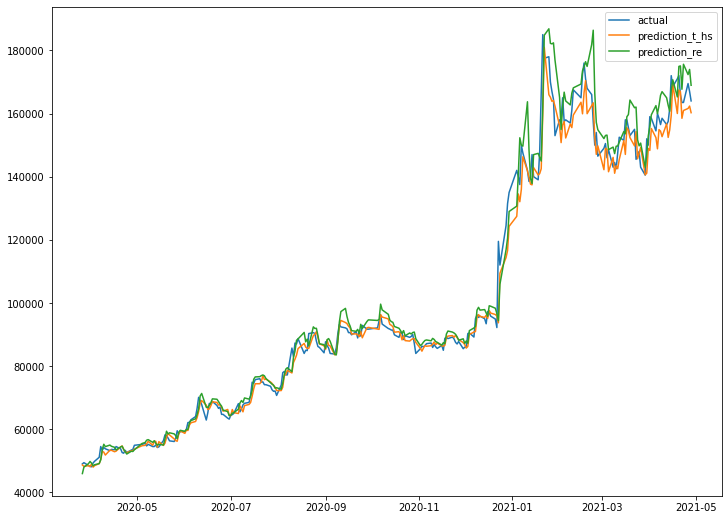

In [ ]:
time_list = test.Date[-(TEST_SIZE-WINDOW_SIZE):]
plt.figure(figsize=(12, 9))
plt.plot(time_list, reverse_min_max_scaling(lg_stock['Close'], test_label_5), label = 'actual')
plt.plot(time_list, reverse_min_max_scaling(lg_stock['Close'], predicted_stock_5_t_hs), label = 'prediction_t_hs')
plt.plot(time_list, reverse_min_max_scaling(lg_stock['Close'], predicted_stock_5_re), label = 'prediction_re')
plt.legend()
plt.show()

In [ ]:
# tanh 함수, hardsigmoid 함수를 쓰는 모델 평가 -> loss = mse = 0.0009150
model_5_t_hs.evaluate(test_feature_5, test_label_5)

9/9 [==============================] - 0s 5ms/step - loss: 9.1502e-04


0.0009150240803137422

In [ ]:
# relu 함수를 쓰는 모델 평가 -> loss = mse = 0.001328
model_5_re.evaluate(test_feature_5, test_label_5)

9/9 [==============================] - 0s 5ms/step - loss: 0.0013


0.0013284601736813784

# YG

In [ ]:
yg_stock[:3]

,Date,Open,High,Low,Close,Volume,Change,Volume_Change,Sentiment
0,2011-11-23,25446,29263,25446,29263,147372,0.000000,147372,0
1,2011-11-24,30498,33641,30498,33641,1575530,0.149609,1428158,2
2,2011-11-25,34426,36372,28926,29787,1429458,-0.114563,-146072,-2


## 정규화

In [ ]:
scaler = MinMaxScaler()

scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'Volume_Change'] # [시가, 고가, 저가, 종가, 거래량, 거래량 변화량]
scaled_data = scaler.fit_transform(yg_stock[scale_cols])
scaled_data = pd.DataFrame(scaled_data)
scaled_data.columns = scale_cols
yg_scaled = pd.concat([yg_stock['Date'], scaled_data, yg_stock['Sentiment']], axis=1)

## LSTM stock data /  1, 4, 6 feature Close, +(Open, High, Low), +(Volume, Sentiment)

In [ ]:
yg_scaled.shape

(2322, 8)

In [ ]:
yg_scaled[:3]

,Date,Open,High,Low,Close,Volume,Volume_Change,Sentiment
0,2011-11-23,0.102226,0.149595,0.117803,0.162048,0.021035,0.595706,0
1,2011-11-24,0.190568,0.221070,0.209419,0.234345,0.266575,0.749837,2
2,2011-11-25,0.259255,0.265657,0.180911,0.170701,0.241461,0.560393,-2


In [ ]:
TEST_SIZE = 300    # 최근 20일간의 주가를 예측하겠다
WINDOW_SIZE = 30   # 5일의 데이터를 기반으로 다음날 주가를 예측하겠다

train = yg_scaled[:-TEST_SIZE]     
test = yg_scaled[-TEST_SIZE:]      # 최근 20일간의 데이터 -> test 데이터

In [ ]:
feature_cols_1 = ['Close']
feature_cols_4 = ['Close', 'Open', 'High', 'Low']
feature_cols_6 = ['Close', 'Open', 'High', 'Low', 'Volume', 'Sentiment']    # 특성 값 6개
label_cols = ['Close']  # label 데이터(종가)

train_feature_1 = train[feature_cols_1]
train_feature_4 = train[feature_cols_4]
train_feature_6 = train[feature_cols_6]
train_label = train[label_cols]

# train dataset 생성
train_feature_1, train_label_1 = make_dataset(train_feature_1, train_label, WINDOW_SIZE)
train_feature_4, train_label_4 = make_dataset(train_feature_4, train_label, WINDOW_SIZE)
train_feature_6, train_label_6 = make_dataset(train_feature_6, train_label, WINDOW_SIZE)

# train, validation set 생성
x_train_1, x_valid_1, y_train_1, y_valid_1 = train_test_split(train_feature_1, train_label_1, test_size=0.2)
x_train_4, x_valid_4, y_train_4, y_valid_4 = train_test_split(train_feature_4, train_label_4, test_size=0.2)
x_train_6, x_valid_6, y_train_6, y_valid_6 = train_test_split(train_feature_6, train_label_6, test_size=0.2)

# test dataset (실제 예측 해볼 데이터)
test_feature_1 = test[feature_cols_1]
test_feature_4 = test[feature_cols_4]
test_feature_6 = test[feature_cols_6]
test_label = test[label_cols]

test_feature_1, test_label_1 = make_dataset(test_feature_1, test_label, WINDOW_SIZE)
test_feature_4, test_label_4 = make_dataset(test_feature_4, test_label, WINDOW_SIZE)
test_feature_6, test_label_6 = make_dataset(test_feature_6, test_label, WINDOW_SIZE)

In [ ]:
model_1 = Sequential()
model_1.add(LSTM(32, input_shape=(train_feature_1.shape[1], train_feature_1.shape[2]), activation='tanh', recurrent_activation='hard_sigmoid', return_sequences=False, kernel_initializer='he_normal' ))
model_1.add(Dense(1))
model_1.compile(optimizer='adam', loss='mean_squared_error')  # 손실함수 = mse

# 조기종료
early_stop = EarlyStopping(monitor='val_loss', patience=5)  # 5번 연속 개선이 없으면 조기종료

# best 모델 저장
checkpoint = ModelCheckpoint('yg_1.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history_1 = model_1.fit(x_train_1, y_train_1, epochs=200, batch_size=16, validation_data=(x_valid_1, y_valid_1), 
                    callbacks=[early_stop, checkpoint])

Epoch 1/200
100/100 [==============================] - 4s 24ms/step - loss: 0.0041 - val_loss: 0.0015

Epoch 00001: val_loss improved from inf to 0.00155, saving model to yg_1.h5
Epoch 2/200
100/100 [==============================] - 2s 21ms/step - loss: 0.0012 - val_loss: 0.0010

Epoch 00002: val_loss improved from 0.00155 to 0.00104, saving model to yg_1.h5
Epoch 3/200
100/100 [==============================] - 2s 20ms/step - loss: 0.0012 - val_loss: 8.0185e-04

Epoch 00003: val_loss improved from 0.00104 to 0.00080, saving model to yg_1.h5
Epoch 4/200
100/100 [==============================] - 2s 21ms/step - loss: 7.5354e-04 - val_loss: 7.2875e-04

Epoch 00004: val_loss improved from 0.00080 to 0.00073, saving model to yg_1.h5
Epoch 5/200
100/100 [==============================] - 2s 21ms/step - loss: 6.2181e-04 - val_loss: 5.9582e-04

Epoch 00005: val_loss improved from 0.00073 to 0.00060, saving model to yg_1.h5
Epoch 6/200
100/100 [==============================] - 2s 21ms/step -

In [ ]:
# tanh 함수, hardsigmoid 함수를 쓰는 모델
predicted_stock_1 = model_1.predict(test_feature_1)

In [ ]:
model_4 = Sequential()
model_4.add(LSTM(32, input_shape=(train_feature_4.shape[1], train_feature_4.shape[2]), activation='tanh', recurrent_activation='hard_sigmoid', return_sequences=False, kernel_initializer='he_normal' ))
model_4.add(Dense(1))
model_4.compile(optimizer='adam', loss='mean_squared_error')  # 손실함수 = mse

# 조기종료
early_stop = EarlyStopping(monitor='val_loss', patience=5)  # 5번 연속 개선이 없으면 조기종료

# best 모델 저장
checkpoint = ModelCheckpoint('yg_4.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history_4 = model_4.fit(x_train_4, y_train_4, epochs=200, batch_size=16, validation_data=(x_valid_4, y_valid_4), 
                    callbacks=[early_stop, checkpoint])

Epoch 1/200
100/100 [==============================] - 4s 23ms/step - loss: 0.0169 - val_loss: 6.4295e-04

Epoch 00001: val_loss improved from inf to 0.00064, saving model to yg_4.h5
Epoch 2/200
100/100 [==============================] - 2s 21ms/step - loss: 5.6202e-04 - val_loss: 6.3283e-04

Epoch 00002: val_loss improved from 0.00064 to 0.00063, saving model to yg_4.h5
Epoch 3/200
100/100 [==============================] - 2s 20ms/step - loss: 4.5466e-04 - val_loss: 5.0175e-04

Epoch 00003: val_loss improved from 0.00063 to 0.00050, saving model to yg_4.h5
Epoch 4/200
100/100 [==============================] - 2s 21ms/step - loss: 4.9668e-04 - val_loss: 4.9586e-04

Epoch 00004: val_loss improved from 0.00050 to 0.00050, saving model to yg_4.h5
Epoch 5/200
100/100 [==============================] - 2s 22ms/step - loss: 5.5383e-04 - val_loss: 4.6712e-04

Epoch 00005: val_loss improved from 0.00050 to 0.00047, saving model to yg_4.h5
Epoch 6/200
100/100 [==============================] 

In [ ]:
# tanh 함수, hardsigmoid 함수를 쓰는 모델
predicted_stock_4 = model_4.predict(test_feature_4)

In [ ]:
model_6 = Sequential()
model_6.add(LSTM(32, input_shape=(train_feature_6.shape[1], train_feature_6.shape[2]), activation='tanh', recurrent_activation='hard_sigmoid', return_sequences=False, kernel_initializer='he_normal' ))
model_6.add(Dense(1))
model_6.compile(optimizer='adam', loss='mean_squared_error')  # 손실함수 = mse

# 조기종료
early_stop = EarlyStopping(monitor='val_loss', patience=5)  # 5번 연속 개선이 없으면 조기종료

# best 모델 저장
checkpoint = ModelCheckpoint('yg_6.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history_6 = model_6.fit(x_train_6, y_train_6, epochs=200, batch_size=16, validation_data=(x_valid_6, y_valid_6), 
                    callbacks=[early_stop, checkpoint])

In [ ]:
# tanh 함수, hardsigmoid 함수를 쓰는 모델
predicted_stock_6 = model_6.predict(test_feature_6)

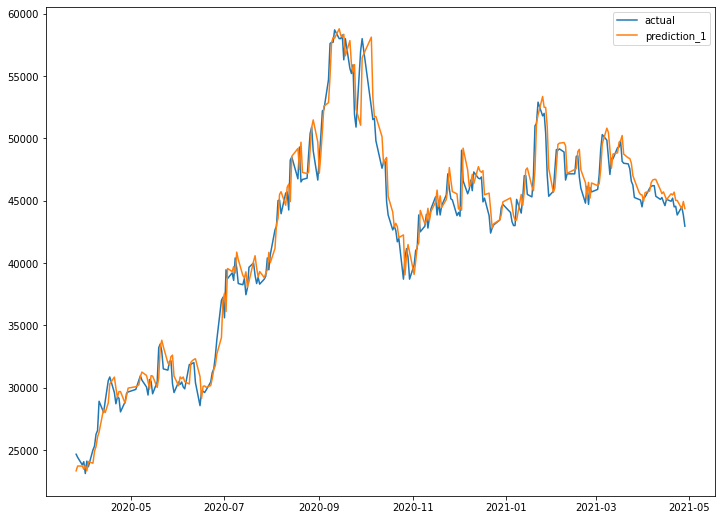

In [ ]:
time_list = test.Date[-(TEST_SIZE-WINDOW_SIZE):]
plt.figure(figsize=(12, 9))
plt.plot(time_list, reverse_min_max_scaling(yg_stock['Close'], test_label_1), label = 'actual')
plt.plot(time_list, reverse_min_max_scaling(yg_stock['Close'], predicted_stock_1), label = 'prediction_1')
#plt.plot(time_list, reverse_min_max_scaling(yg_stock['Close'], predicted_stock_4), label = 'prediction_4')
#plt.plot(time_list, reverse_min_max_scaling(yg_stock['Close'], predicted_stock_6), label = 'prediction_6')
plt.legend()
plt.show()

In [ ]:
# close를 특성으로 가지는 모델 평가 -> loss = mse = 0.0005471 / 0.0005536
model_1.evaluate(test_feature_1, test_label_1)

9/9 [==============================] - 0s 4ms/step - loss: 5.5360e-04


0.0005536040407605469

In [ ]:
# close, open, high, row를 특성으로 가지는 모델 평가 -> loss = mse = 0.0005234 / 0.0005728
model_4.evaluate(test_feature_4, test_label_4)

9/9 [==============================] - 0s 4ms/step - loss: 5.7289e-04


0.00057289405958727

In [ ]:
# close, open, high, row, volume, sentiment를 특성으로 가지는 모델 평가 -> loss = mse = 0.0007453 / 0.0009770
model_6.evaluate(test_feature_6, test_label_6)

9/9 [==============================] - 0s 4ms/step - loss: 9.7710e-04


0.0009770975448191166

# JYP

In [ ]:
jyp_stock.shape

(4860, 9)

In [ ]:
jyp_stock[:3]

,Date,Open,High,Low,Close,Volume,Change,Volume_Change,Sentiment
0,2001-08-30,14907392,14907392,14907392,14907392,5473275,0.000000,5473275,0
1,2001-08-31,13118598,13118598,13118598,13118506,564485,-0.120000,-4908790,-2
2,2001-09-03,11561544,11561544,11561544,11561510,275360,-0.118687,-289125,-2


## 정규화

In [9]:
scaler = MinMaxScaler()

scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'Volume_Change'] # [시가, 고가, 저가, 종가, 거래량, 거래량 변화량]
scaled_data = scaler.fit_transform(jyp_stock[scale_cols])
scaled_data = pd.DataFrame(scaled_data)
scaled_data.columns = scale_cols
jyp_scaled = pd.concat([jyp_stock['Date'], scaled_data, jyp_stock['Sentiment']], axis=1)

## LSTM stock data / activation, recurrent_activation, kernel_intializer, bias initializer, 순환층 개수, drop_out

In [10]:
jyp_scaled[:3]

,Date,Open,High,Low,Close,Volume,Volume_Change,Sentiment
0,2001-08-30,0.592102,0.576920,0.608107,0.593650,0.075211,0.484463,0
1,2001-08-31,0.521054,0.507693,0.535138,0.522407,0.007757,0.383559,-2
2,2001-09-03,0.459210,0.447435,0.471622,0.460399,0.003784,0.428458,-2


In [11]:
TEST_SIZE = 300    # 최근 20일간의 주가를 예측하겠다
WINDOW_SIZE = 30   # 5일의 데이터를 기반으로 다음날 주가를 예측하겠다

train = jyp_scaled[:-TEST_SIZE]     
test = jyp_scaled[-TEST_SIZE:]      # 최근 20일간의 데이터 -> test 데이터

In [12]:
feature_cols = ['Open', 'High', 'Low', 'Volume', 'Sentiment']    # 특성 값 5개 고정
label_cols = ['Close']  # label 데이터(종가)

train_feature = train[feature_cols]
train_label = train[label_cols]

# train dataset 생성
train_feature, train_label = make_dataset(train_feature, train_label, WINDOW_SIZE)

# train, validation set 생성
x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)

# test dataset (실제 예측 해볼 데이터)
test_feature = test[feature_cols]
test_label = test[label_cols]

test_feature, test_label = make_dataset(test_feature, test_label, WINDOW_SIZE)

### 1. activation - relu / optimizer = adam

In [ ]:
model_1 = Sequential()
model_1.add(LSTM(32, input_shape=(train_feature.shape[1], train_feature.shape[2]), activation='relu', return_sequences=False))
model_1.add(Dense(1))
model_1.compile(optimizer='adam', loss='mean_squared_error')  # 손실함수 = mse

# 조기종료
early_stop = EarlyStopping(monitor='val_loss', patience=20)  # 5번 연속 개선이 없으면 조기종료

# best 모델 저장
checkpoint = ModelCheckpoint('jyp_1.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history_1 = model_1.fit(x_train, y_train, epochs=100, batch_size=16, validation_data=(x_valid, y_valid), 
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
227/227 [==============================] - 4s 12ms/step - loss: 0.0022 - val_loss: 1.5138e-04

Epoch 00001: val_loss improved from inf to 0.00015, saving model to jyp_1.h5
Epoch 2/100
227/227 [==============================] - 3s 11ms/step - loss: 8.6028e-05 - val_loss: 8.6975e-05

Epoch 00002: val_loss improved from 0.00015 to 0.00009, saving model to jyp_1.h5
Epoch 3/100
227/227 [==============================] - 3s 12ms/step - loss: 9.9191e-05 - val_loss: 6.8979e-05

Epoch 00003: val_loss improved from 0.00009 to 0.00007, saving model to jyp_1.h5
Epoch 4/100
227/227 [==============================] - 3s 12ms/step - loss: 7.8295e-05 - val_loss: 1.1959e-04

Epoch 00004: val_loss did not improve from 0.00007
Epoch 5/100
227/227 [==============================] - 3s 12ms/step - loss: 1.1080e-04 - val_loss: 1.1919e-04

Epoch 00005: val_loss did not improve from 0.00007
Epoch 6/100
227/227 [==============================] - 3s 11ms/step - loss: 8.1724e-05 - val_loss: 1.0088e-0

In [ ]:
# activation = relu  / optimizer = adam
predicted_stock_1 = model_1.predict(test_feature)

### 2. activation = relu  / optimizer = adagrad

In [ ]:
model_2 = Sequential()
model_2.add(LSTM(32, input_shape=(train_feature.shape[1], train_feature.shape[2]), activation='relu', return_sequences=False))
model_2.add(Dense(1))
model_2.compile(optimizer='adagrad', loss='mean_squared_error')  # 손실함수 = mse

# 조기종료
early_stop = EarlyStopping(monitor='val_loss', patience=20)  # 5번 연속 개선이 없으면 조기종료

# best 모델 저장
checkpoint = ModelCheckpoint('jyp_2.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history_2 = model_2.fit(x_train, y_train, epochs=100, batch_size=16, validation_data=(x_valid, y_valid), 
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
227/227 [==============================] - 4s 13ms/step - loss: 0.0250 - val_loss: 0.0230

Epoch 00001: val_loss improved from inf to 0.02305, saving model to jyp_2.h5
Epoch 2/100
227/227 [==============================] - 3s 12ms/step - loss: 0.0190 - val_loss: 0.0204

Epoch 00002: val_loss improved from 0.02305 to 0.02045, saving model to jyp_2.h5
Epoch 3/100
227/227 [==============================] - 3s 12ms/step - loss: 0.0200 - val_loss: 0.0186

Epoch 00003: val_loss improved from 0.02045 to 0.01864, saving model to jyp_2.h5
Epoch 4/100
227/227 [==============================] - 3s 12ms/step - loss: 0.0189 - val_loss: 0.0172

Epoch 00004: val_loss improved from 0.01864 to 0.01722, saving model to jyp_2.h5
Epoch 5/100
227/227 [==============================] - 3s 11ms/step - loss: 0.0140 - val_loss: 0.0160

Epoch 00005: val_loss improved from 0.01722 to 0.01599, saving model to jyp_2.h5
Epoch 6/100
227/227 [==============================] - 3s 11ms/step - loss: 0.0151 -

In [ ]:
# activation = relu  / optimizer = adagrad
predicted_stock_2 = model_2.predict(test_feature)

### 3. activation = relu  / optimizer = adadelta

In [ ]:
model_3 = Sequential()
model_3.add(LSTM(32, input_shape=(train_feature.shape[1], train_feature.shape[2]), activation='relu', return_sequences=False))
model_3.add(Dense(1))
model_3.compile(optimizer='adadelta', loss='mean_squared_error')  # 손실함수 = mse

# 조기종료
early_stop = EarlyStopping(monitor='val_loss', patience=20)  # 5번 연속 개선이 없으면 조기종료

# best 모델 저장
checkpoint = ModelCheckpoint('jyp_3.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history_3 = model_3.fit(x_train, y_train, epochs=100, batch_size=16, validation_data=(x_valid, y_valid), 
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
227/227 [==============================] - 4s 13ms/step - loss: 0.0189 - val_loss: 0.0225

Epoch 00001: val_loss improved from inf to 0.02248, saving model to jyp_3.h5
Epoch 2/100
227/227 [==============================] - 3s 12ms/step - loss: 0.0188 - val_loss: 0.0218

Epoch 00002: val_loss improved from 0.02248 to 0.02177, saving model to jyp_3.h5
Epoch 3/100
227/227 [==============================] - 3s 12ms/step - loss: 0.0221 - val_loss: 0.0211

Epoch 00003: val_loss improved from 0.02177 to 0.02111, saving model to jyp_3.h5
Epoch 4/100
227/227 [==============================] - 3s 12ms/step - loss: 0.0234 - val_loss: 0.0205

Epoch 00004: val_loss improved from 0.02111 to 0.02048, saving model to jyp_3.h5
Epoch 5/100
227/227 [==============================] - 3s 11ms/step - loss: 0.0176 - val_loss: 0.0199

Epoch 00005: val_loss improved from 0.02048 to 0.01991, saving model to jyp_3.h5
Epoch 6/100
227/227 [==============================] - 3s 12ms/step - loss: 0.0181 -

In [ ]:
# activation = relu  / optimizer = adadelta
predicted_stock_3 = model_3.predict(test_feature)

### 4. activation = relu  / optimizer = adamax

In [ ]:
model_4 = Sequential()
model_4.add(LSTM(32, input_shape=(train_feature.shape[1], train_feature.shape[2]), activation='relu', return_sequences=False))
model_4.add(Dense(1))
model_4.compile(optimizer='adamax', loss='mean_squared_error')  # 손실함수 = mse

# 조기종료
early_stop = EarlyStopping(monitor='val_loss', patience=20)  # 5번 연속 개선이 없으면 조기종료

# best 모델 저장
checkpoint = ModelCheckpoint('jyp_4.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history_4 = model_4.fit(x_train, y_train, epochs=100, batch_size=16, validation_data=(x_valid, y_valid), 
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
227/227 [==============================] - 4s 13ms/step - loss: 0.0080 - val_loss: 2.4355e-04

Epoch 00001: val_loss improved from inf to 0.00024, saving model to jyp_4.h5
Epoch 2/100
227/227 [==============================] - 3s 11ms/step - loss: 1.8196e-04 - val_loss: 1.3838e-04

Epoch 00002: val_loss improved from 0.00024 to 0.00014, saving model to jyp_4.h5
Epoch 3/100
227/227 [==============================] - 3s 11ms/step - loss: 1.4889e-04 - val_loss: 1.1490e-04

Epoch 00003: val_loss improved from 0.00014 to 0.00011, saving model to jyp_4.h5
Epoch 4/100
227/227 [==============================] - 3s 12ms/step - loss: 9.5549e-05 - val_loss: 9.8797e-05

Epoch 00004: val_loss improved from 0.00011 to 0.00010, saving model to jyp_4.h5
Epoch 5/100
227/227 [==============================] - 3s 12ms/step - loss: 9.7190e-05 - val_loss: 9.6280e-05

Epoch 00005: val_loss improved from 0.00010 to 0.00010, saving model to jyp_4.h5
Epoch 6/100
227/227 [===========================

In [ ]:
# activation = relu  / optimizer = adamax
predicted_stock_4 = model_4.predict(test_feature)

### 5. activation = relu  / optimizer = nadam

In [ ]:
model_5 = Sequential()
model_5.add(LSTM(32, input_shape=(train_feature.shape[1], train_feature.shape[2]), activation='relu', return_sequences=False))
model_5.add(Dense(1))
model_5.compile(optimizer='nadam', loss='mean_squared_error')  # 손실함수 = mse

# 조기종료
early_stop = EarlyStopping(monitor='val_loss', patience=20)  # 5번 연속 개선이 없으면 조기종료

# best 모델 저장
checkpoint = ModelCheckpoint('jyp_5.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history_5 = model_5.fit(x_train, y_train, epochs=100, batch_size=16, validation_data=(x_valid, y_valid), 
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
227/227 [==============================] - 4s 13ms/step - loss: 0.0072 - val_loss: 2.1687e-04

Epoch 00001: val_loss improved from inf to 0.00022, saving model to jyp_5.h5
Epoch 2/100
227/227 [==============================] - 3s 12ms/step - loss: 1.5452e-04 - val_loss: 1.4683e-04

Epoch 00002: val_loss improved from 0.00022 to 0.00015, saving model to jyp_5.h5
Epoch 3/100
227/227 [==============================] - 3s 12ms/step - loss: 1.1124e-04 - val_loss: 1.1051e-04

Epoch 00003: val_loss improved from 0.00015 to 0.00011, saving model to jyp_5.h5
Epoch 4/100
227/227 [==============================] - 3s 12ms/step - loss: 9.0398e-05 - val_loss: 1.0699e-04

Epoch 00004: val_loss improved from 0.00011 to 0.00011, saving model to jyp_5.h5
Epoch 5/100
227/227 [==============================] - 3s 12ms/step - loss: 7.1780e-05 - val_loss: 9.9394e-05

Epoch 00005: val_loss improved from 0.00011 to 0.00010, saving model to jyp_5.h5
Epoch 6/100
227/227 [===========================

In [ ]:
# activation = relu  / optimizer = nadam
predicted_stock_5 = model_5.predict(test_feature)

### 6. activation = relu  / optimizer = rmsprop

In [ ]:
model_6 = Sequential()
model_6.add(LSTM(32, input_shape=(train_feature.shape[1], train_feature.shape[2]), activation='relu', return_sequences=False))
model_6.add(Dense(1))
model_6.compile(optimizer='rmsprop', loss='mean_squared_error')  # 손실함수 = mse

# 조기종료
early_stop = EarlyStopping(monitor='val_loss', patience=20)  # 5번 연속 개선이 없으면 조기종료

# best 모델 저장
checkpoint = ModelCheckpoint('jyp_6.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history_6 = model_6.fit(x_train, y_train, epochs=100, batch_size=16, validation_data=(x_valid, y_valid), 
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
227/227 [==============================] - 4s 12ms/step - loss: 0.0040 - val_loss: 3.3082e-04

Epoch 00001: val_loss improved from inf to 0.00033, saving model to jyp_6.h5
Epoch 2/100
227/227 [==============================] - 3s 11ms/step - loss: 2.2570e-04 - val_loss: 1.8189e-04

Epoch 00002: val_loss improved from 0.00033 to 0.00018, saving model to jyp_6.h5
Epoch 3/100
227/227 [==============================] - 3s 11ms/step - loss: 1.6635e-04 - val_loss: 3.4415e-04

Epoch 00003: val_loss did not improve from 0.00018
Epoch 4/100
227/227 [==============================] - 3s 11ms/step - loss: 1.7175e-04 - val_loss: 2.5114e-04

Epoch 00004: val_loss did not improve from 0.00018
Epoch 5/100
227/227 [==============================] - 3s 11ms/step - loss: 1.3747e-04 - val_loss: 1.9800e-04

Epoch 00005: val_loss did not improve from 0.00018
Epoch 6/100
227/227 [==============================] - 3s 12ms/step - loss: 1.1642e-04 - val_loss: 7.5543e-05

Epoch 00006: val_loss impro

In [ ]:
# activation = relu  / optimizer = rmsprop
predicted_stock_6 = model_6.predict(test_feature)

### 7. activation = relu  / optimizer = sgd

In [ ]:
model_7 = Sequential()
model_7.add(LSTM(32, input_shape=(train_feature.shape[1], train_feature.shape[2]), activation='relu', return_sequences=False))
model_7.add(Dense(1))
model_7.compile(optimizer='sgd', loss='mean_squared_error')  # 손실함수 = mse

# 조기종료
early_stop = EarlyStopping(monitor='val_loss', patience=20)  # 5번 연속 개선이 없으면 조기종료

# best 모델 저장
checkpoint = ModelCheckpoint('jyp_7.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history_7 = model_7.fit(x_train, y_train, epochs=100, batch_size=16, validation_data=(x_valid, y_valid), 
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
227/227 [==============================] - 4s 12ms/step - loss: 0.0141 - val_loss: 0.0106

Epoch 00001: val_loss improved from inf to 0.01057, saving model to jyp_7.h5
Epoch 2/100
227/227 [==============================] - 3s 12ms/step - loss: 0.0083 - val_loss: 0.0079

Epoch 00002: val_loss improved from 0.01057 to 0.00786, saving model to jyp_7.h5
Epoch 3/100
227/227 [==============================] - 3s 11ms/step - loss: 0.0069 - val_loss: 0.0061

Epoch 00003: val_loss improved from 0.00786 to 0.00612, saving model to jyp_7.h5
Epoch 4/100
227/227 [==============================] - 3s 11ms/step - loss: 0.0051 - val_loss: 0.0048

Epoch 00004: val_loss improved from 0.00612 to 0.00477, saving model to jyp_7.h5
Epoch 5/100
227/227 [==============================] - 3s 11ms/step - loss: 0.0041 - val_loss: 0.0036

Epoch 00005: val_loss improved from 0.00477 to 0.00364, saving model to jyp_7.h5
Epoch 6/100
227/227 [==============================] - 3s 11ms/step - loss: 0.0034 -

In [ ]:
# activation = relu  / optimizer = sgd
predicted_stock_7 = model_7.predict(test_feature)

### 1 ~ 7 optimizer 평가  -> 4번째 결과부터 tanh-hard_sigmoid


In [ ]:
# optimizer = adam  -> 6.864e-06 / 1.0220e-05 / 5.3790e-06 / 6.9394e-07 / 9.2243e-06 / 1.0590e-05
model_1.evaluate(test_feature, test_label)

9/9 [==============================] - 0s 3ms/step - loss: 1.0220e-05


1.0220299373031594e-05

In [ ]:
# optimizer = adagrad -> 3.944e-05 / 2.5929e-05 / 5.1521e-05
model_2.evaluate(test_feature, test_label)

9/9 [==============================] - 0s 4ms/step - loss: 2.5929e-05


2.592911732790526e-05

In [ ]:
# optimizer = adadelta -> 5.0617e-04 / 3.5198e-04 / 6.1156e-04
model_3.evaluate(test_feature, test_label)

9/9 [==============================] - 0s 4ms/step - loss: 3.5198e-04


0.0003519783786032349

In [ ]:
# optimizer = adamax -> 1.8557e-06 / 1.2575e-06 / 3.7624e-06 / 2.4150e-06 / 1.6215e-06 /5.4342e-07
model_4.evaluate(test_feature, test_label)

9/9 [==============================] - 0s 3ms/step - loss: 1.2575e-06


1.257487610928365e-06

In [ ]:
# optimizer = nadam -> 2.9473e-06 / 2.5997e-05 / 1.5022e-06 / 3.3108e-06 / 9.7543e-07 / 1.1737e-05
model_5.evaluate(test_feature, test_label)

9/9 [==============================] - 0s 5ms/step - loss: 2.5997e-05


2.5996849217335694e-05

In [ ]:
# optimizer = rmsprop -> 7.7177e-06 / 1.9267e-06 / 3.1583e-06 / 4.2171e-06 / 2.4550e-07 / 6.1557e-07
model_6.evaluate(test_feature, test_label)

9/9 [==============================] - 0s 4ms/step - loss: 1.9267e-06


1.926703134813579e-06

In [ ]:
# optimizer = sgd -> 1.1709e-05 / 7.0254e-06 / 6.2248e-06
model_7.evaluate(test_feature, test_label)

9/9 [==============================] - 0s 5ms/step - loss: 7.0254e-06


7.0254104684863705e-06

### activation - recurrent_activation 

#### relu

In [ ]:
model_4_1 = Sequential()
model_4_1.add(LSTM(32, input_shape=(train_feature.shape[1], train_feature.shape[2]), activation='relu', return_sequences=False))
model_4_1.add(Dense(1))
model_4_1.compile(optimizer='adamax', loss='mean_squared_error') 

# 조기종료
early_stop = EarlyStopping(monitor='val_loss', patience=20)
# best 모델 저장
checkpoint = ModelCheckpoint('jyp_4_1.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history_4_1 = model_4_1.fit(x_train, y_train, epochs=100, batch_size=16, validation_data=(x_valid, y_valid), 
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
227/227 [==============================] - 4s 12ms/step - loss: 0.0061 - val_loss: 4.4397e-04

Epoch 00001: val_loss improved from inf to 0.00044, saving model to jyp_4_1.h5
Epoch 2/100
227/227 [==============================] - 3s 11ms/step - loss: 4.1266e-04 - val_loss: 2.4441e-04

Epoch 00002: val_loss improved from 0.00044 to 0.00024, saving model to jyp_4_1.h5
Epoch 3/100
227/227 [==============================] - 3s 11ms/step - loss: 1.8736e-04 - val_loss: 1.3937e-04

Epoch 00003: val_loss improved from 0.00024 to 0.00014, saving model to jyp_4_1.h5
Epoch 4/100
227/227 [==============================] - 3s 11ms/step - loss: 1.3597e-04 - val_loss: 1.1242e-04

Epoch 00004: val_loss improved from 0.00014 to 0.00011, saving model to jyp_4_1.h5
Epoch 5/100
227/227 [==============================] - 3s 11ms/step - loss: 9.4854e-05 - val_loss: 9.4749e-05

Epoch 00005: val_loss improved from 0.00011 to 0.00009, saving model to jyp_4_1.h5
Epoch 6/100
227/227 [=================

In [ ]:
# activation = relu 
predicted_stock_4_1 = model_4_1.predict(test_feature)

#### tanh - linear

In [ ]:
model_4_2 = Sequential()
model_4_2.add(LSTM(32, input_shape=(train_feature.shape[1], train_feature.shape[2]), activation='tanh', recurrent_activation='linear', return_sequences=False))
model_4_2.add(Dense(1))
model_4_2.compile(optimizer='adamax', loss='mean_squared_error') 

# 조기종료
early_stop = EarlyStopping(monitor='val_loss', patience=20)
# best 모델 저장
checkpoint = ModelCheckpoint('jyp_4_2.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history_4_2 = model_4_2.fit(x_train, y_train, epochs=100, batch_size=16, validation_data=(x_valid, y_valid), 
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
227/227 [==============================] - 4s 12ms/step - loss: 0.0047 - val_loss: 4.5509e-04

Epoch 00001: val_loss improved from inf to 0.00046, saving model to jyp_4_2.h5
Epoch 2/100
227/227 [==============================] - 3s 11ms/step - loss: 3.3509e-04 - val_loss: 2.8151e-04

Epoch 00002: val_loss improved from 0.00046 to 0.00028, saving model to jyp_4_2.h5
Epoch 3/100
227/227 [==============================] - 3s 11ms/step - loss: 2.1790e-04 - val_loss: 1.9891e-04

Epoch 00003: val_loss improved from 0.00028 to 0.00020, saving model to jyp_4_2.h5
Epoch 4/100
227/227 [==============================] - 3s 11ms/step - loss: 1.6939e-04 - val_loss: 1.6687e-04

Epoch 00004: val_loss improved from 0.00020 to 0.00017, saving model to jyp_4_2.h5
Epoch 5/100
227/227 [==============================] - 3s 11ms/step - loss: 1.2628e-04 - val_loss: 1.7734e-04

Epoch 00005: val_loss did not improve from 0.00017
Epoch 6/100
227/227 [==============================] - 2s 11ms/step - 

In [ ]:
# activation = tanh / recurrent_activation = linear
predicted_stock_4_2 = model_4_2.predict(test_feature)

#### tanh - hard_sigmoid

In [ ]:
model_4_3 = Sequential()
model_4_3.add(LSTM(32, input_shape=(train_feature.shape[1], train_feature.shape[2]), activation='tanh', recurrent_activation='hard_sigmoid', return_sequences=False))
model_4_3.add(Dense(1))
model_4_3.compile(optimizer='adamax', loss='mean_squared_error') 

# 조기종료
early_stop = EarlyStopping(monitor='val_loss', patience=20)
# best 모델 저장
checkpoint = ModelCheckpoint('jyp_4_3.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history_4_3 = model_4_3.fit(x_train, y_train, epochs=100, batch_size=16, validation_data=(x_valid, y_valid), 
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
227/227 [==============================] - 7s 21ms/step - loss: 0.0031 - val_loss: 2.1512e-04

Epoch 00001: val_loss improved from inf to 0.00022, saving model to jyp_4_3.h5
Epoch 2/100
227/227 [==============================] - 5s 20ms/step - loss: 2.4901e-04 - val_loss: 1.4260e-04

Epoch 00002: val_loss improved from 0.00022 to 0.00014, saving model to jyp_4_3.h5
Epoch 3/100
227/227 [==============================] - 5s 20ms/step - loss: 1.2987e-04 - val_loss: 1.0187e-04

Epoch 00003: val_loss improved from 0.00014 to 0.00010, saving model to jyp_4_3.h5
Epoch 4/100
227/227 [==============================] - 4s 20ms/step - loss: 1.0514e-04 - val_loss: 9.0812e-05

Epoch 00004: val_loss improved from 0.00010 to 0.00009, saving model to jyp_4_3.h5
Epoch 5/100
227/227 [==============================] - 5s 20ms/step - loss: 9.6156e-05 - val_loss: 9.1882e-05

Epoch 00005: val_loss did not improve from 0.00009
Epoch 6/100
227/227 [==============================] - 5s 20ms/step - 

In [ ]:
# activation = tanh / recurrent_activation = hard_sigmoid
predicted_stock_4_3 = model_4_3.predict(test_feature)

#### activation - recurrent_activation  평가

In [ ]:
# activation = relu  ->  1.9176e-06  / 8.3684e-07 / 1.2828e-05
model_4_1.evaluate(test_feature, test_label)

9/9 [==============================] - 0s 4ms/step - loss: 1.2828e-05


1.2828311810153536e-05

In [ ]:
# activation = tanh / recurrent_activation = linear -> 2.9535e-06 / 3.5202e-06 /2.3714e-06
model_4_2.evaluate(test_feature, test_label)

9/9 [==============================] - 0s 3ms/step - loss: 2.3714e-06


2.3714080725767417e-06

In [ ]:
# activation = tanh / recurrent_activation = hard_sigmoid -> 1.6311e-06 / 5.9564e-07 / 3.5748e-06
model_4_3.evaluate(test_feature, test_label)

9/9 [==============================] - 0s 5ms/step - loss: 3.5748e-06


3.5747500533034327e-06

### kernel_intializer

#### lecun_uniform

In [55]:
model_4_3_1 = Sequential()
model_4_3_1.add(LSTM(32, input_shape=(train_feature.shape[1], train_feature.shape[2]),
                     activation='tanh', recurrent_activation='hard_sigmoid', kernel_initializer='lecun_uniform' ,
                     return_sequences=False))
model_4_3_1.add(Dense(1))
model_4_3_1.compile(optimizer='adamax', loss='mean_squared_error') 

# 조기종료
early_stop = EarlyStopping(monitor='val_loss', patience=20)
# best 모델 저장
checkpoint = ModelCheckpoint('jyp_4_3_1.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history_4_3_1 = model_4_3_1.fit(x_train, y_train, epochs=100, batch_size=16, validation_data=(x_valid, y_valid), 
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
227/227 [==============================] - 7s 23ms/step - loss: 0.0082 - val_loss: 9.7834e-04

Epoch 00001: val_loss improved from inf to 0.00098, saving model to jyp_4_3_1.h5
Epoch 2/100
227/227 [==============================] - 5s 22ms/step - loss: 0.0011 - val_loss: 5.8225e-04

Epoch 00002: val_loss improved from 0.00098 to 0.00058, saving model to jyp_4_3_1.h5
Epoch 3/100
227/227 [==============================] - 5s 22ms/step - loss: 9.0449e-04 - val_loss: 4.8882e-04

Epoch 00003: val_loss improved from 0.00058 to 0.00049, saving model to jyp_4_3_1.h5
Epoch 4/100
227/227 [==============================] - 5s 22ms/step - loss: 7.7422e-04 - val_loss: 4.0886e-04

Epoch 00004: val_loss improved from 0.00049 to 0.00041, saving model to jyp_4_3_1.h5
Epoch 5/100
227/227 [==============================] - 5s 21ms/step - loss: 4.5382e-04 - val_loss: 3.3910e-04

Epoch 00005: val_loss improved from 0.00041 to 0.00034, saving model to jyp_4_3_1.h5
Epoch 6/100
227/227 [===========

In [56]:
predicted_stock_4_3_1 = model_4_3_1.predict(test_feature)

#### lecun_normal

In [57]:
model_4_3_2 = Sequential()
model_4_3_2.add(LSTM(32, input_shape=(train_feature.shape[1], train_feature.shape[2]),
                     activation='tanh', recurrent_activation='hard_sigmoid', kernel_initializer='lecun_normal' ,
                     return_sequences=False))
model_4_3_2.add(Dense(1))
model_4_3_2.compile(optimizer='adamax', loss='mean_squared_error') 

# 조기종료
early_stop = EarlyStopping(monitor='val_loss', patience=20)
# best 모델 저장
checkpoint = ModelCheckpoint('jyp_4_3_2.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history_4_3_2 = model_4_3_2.fit(x_train, y_train, epochs=100, batch_size=16, validation_data=(x_valid, y_valid), 
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
227/227 [==============================] - 7s 23ms/step - loss: 0.0180 - val_loss: 0.0027

Epoch 00001: val_loss improved from inf to 0.00270, saving model to jyp_4_3_2.h5
Epoch 2/100
227/227 [==============================] - 5s 22ms/step - loss: 0.0028 - val_loss: 0.0014

Epoch 00002: val_loss improved from 0.00270 to 0.00135, saving model to jyp_4_3_2.h5
Epoch 3/100
227/227 [==============================] - 5s 22ms/step - loss: 0.0014 - val_loss: 8.7420e-04

Epoch 00003: val_loss improved from 0.00135 to 0.00087, saving model to jyp_4_3_2.h5
Epoch 4/100
227/227 [==============================] - 5s 22ms/step - loss: 9.6732e-04 - val_loss: 5.7002e-04

Epoch 00004: val_loss improved from 0.00087 to 0.00057, saving model to jyp_4_3_2.h5
Epoch 5/100
227/227 [==============================] - 5s 22ms/step - loss: 6.6508e-04 - val_loss: 4.2543e-04

Epoch 00005: val_loss improved from 0.00057 to 0.00043, saving model to jyp_4_3_2.h5
Epoch 6/100
227/227 [=======================

In [58]:
predicted_stock_4_3_2 = model_4_3_2.predict(test_feature)

#### glorot_uniform

In [59]:
model_4_3_3 = Sequential()
model_4_3_3.add(LSTM(32, input_shape=(train_feature.shape[1], train_feature.shape[2]),
                     activation='tanh', recurrent_activation='hard_sigmoid', kernel_initializer='glorot_uniform' ,
                     return_sequences=False))
model_4_3_3.add(Dense(1))
model_4_3_3.compile(optimizer='adamax', loss='mean_squared_error') 

# 조기종료
early_stop = EarlyStopping(monitor='val_loss', patience=20)
# best 모델 저장
checkpoint = ModelCheckpoint('jyp_4_3_3.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history_4_3_3 = model_4_3_3.fit(x_train, y_train, epochs=100, batch_size=16, validation_data=(x_valid, y_valid), 
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
227/227 [==============================] - 7s 23ms/step - loss: 0.0061 - val_loss: 1.1108e-04

Epoch 00001: val_loss improved from inf to 0.00011, saving model to jyp_4_3_3.h5
Epoch 2/100
227/227 [==============================] - 5s 21ms/step - loss: 2.0714e-04 - val_loss: 7.9315e-05

Epoch 00002: val_loss improved from 0.00011 to 0.00008, saving model to jyp_4_3_3.h5
Epoch 3/100
227/227 [==============================] - 5s 21ms/step - loss: 1.1485e-04 - val_loss: 8.0554e-05

Epoch 00003: val_loss did not improve from 0.00008
Epoch 4/100
227/227 [==============================] - 5s 21ms/step - loss: 1.0505e-04 - val_loss: 6.3557e-05

Epoch 00004: val_loss improved from 0.00008 to 0.00006, saving model to jyp_4_3_3.h5
Epoch 5/100
227/227 [==============================] - 5s 21ms/step - loss: 1.1706e-04 - val_loss: 5.1956e-05

Epoch 00005: val_loss improved from 0.00006 to 0.00005, saving model to jyp_4_3_3.h5
Epoch 6/100
227/227 [==============================] - 5s 21ms

In [60]:
predicted_stock_4_3_3 = model_4_3_3.predict(test_feature)

#### glorot_normal

In [61]:
model_4_3_4 = Sequential()
model_4_3_4.add(LSTM(32, input_shape=(train_feature.shape[1], train_feature.shape[2]),
                     activation='tanh', recurrent_activation='hard_sigmoid', kernel_initializer='glorot_normal' ,
                     return_sequences=False))
model_4_3_4.add(Dense(1))
model_4_3_4.compile(optimizer='adamax', loss='mean_squared_error') 

# 조기종료
early_stop = EarlyStopping(monitor='val_loss', patience=20)
# best 모델 저장
checkpoint = ModelCheckpoint('jyp_4_3_4.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history_4_3_4 = model_4_3_4.fit(x_train, y_train, epochs=100, batch_size=16, validation_data=(x_valid, y_valid), 
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
227/227 [==============================] - 8s 23ms/step - loss: 0.0057 - val_loss: 1.3332e-04

Epoch 00001: val_loss improved from inf to 0.00013, saving model to jyp_4_3_4.h5
Epoch 2/100
227/227 [==============================] - 5s 22ms/step - loss: 1.8245e-04 - val_loss: 1.1911e-04

Epoch 00002: val_loss improved from 0.00013 to 0.00012, saving model to jyp_4_3_4.h5
Epoch 3/100
227/227 [==============================] - 5s 22ms/step - loss: 1.2215e-04 - val_loss: 1.0726e-04

Epoch 00003: val_loss improved from 0.00012 to 0.00011, saving model to jyp_4_3_4.h5
Epoch 4/100
227/227 [==============================] - 5s 22ms/step - loss: 1.1940e-04 - val_loss: 7.0111e-05

Epoch 00004: val_loss improved from 0.00011 to 0.00007, saving model to jyp_4_3_4.h5
Epoch 5/100
227/227 [==============================] - 5s 22ms/step - loss: 8.7584e-05 - val_loss: 6.1188e-05

Epoch 00005: val_loss improved from 0.00007 to 0.00006, saving model to jyp_4_3_4.h5
Epoch 6/100
227/227 [=======

In [62]:
predicted_stock_4_3_4 = model_4_3_4.predict(test_feature)

#### he_uniform

In [63]:
model_4_3_5 = Sequential()
model_4_3_5.add(LSTM(32, input_shape=(train_feature.shape[1], train_feature.shape[2]),
                     activation='tanh', recurrent_activation='hard_sigmoid', kernel_initializer='he_uniform' ,
                     return_sequences=False))
model_4_3_5.add(Dense(1))
model_4_3_5.compile(optimizer='adamax', loss='mean_squared_error') 

# 조기종료
early_stop = EarlyStopping(monitor='val_loss', patience=20)
# best 모델 저장
checkpoint = ModelCheckpoint('jyp_4_3_5.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history_4_3_5 = model_4_3_5.fit(x_train, y_train, epochs=100, batch_size=16, validation_data=(x_valid, y_valid), 
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
227/227 [==============================] - 8s 24ms/step - loss: 0.0273 - val_loss: 0.0027

Epoch 00001: val_loss improved from inf to 0.00274, saving model to jyp_4_3_5.h5
Epoch 2/100
227/227 [==============================] - 5s 22ms/step - loss: 0.0023 - val_loss: 0.0013

Epoch 00002: val_loss improved from 0.00274 to 0.00130, saving model to jyp_4_3_5.h5
Epoch 3/100
227/227 [==============================] - 5s 22ms/step - loss: 0.0014 - val_loss: 8.6350e-04

Epoch 00003: val_loss improved from 0.00130 to 0.00086, saving model to jyp_4_3_5.h5
Epoch 4/100
227/227 [==============================] - 5s 22ms/step - loss: 8.3049e-04 - val_loss: 6.4401e-04

Epoch 00004: val_loss improved from 0.00086 to 0.00064, saving model to jyp_4_3_5.h5
Epoch 5/100
227/227 [==============================] - 5s 22ms/step - loss: 6.6036e-04 - val_loss: 4.9936e-04

Epoch 00005: val_loss improved from 0.00064 to 0.00050, saving model to jyp_4_3_5.h5
Epoch 6/100
227/227 [=======================

In [64]:
predicted_stock_4_3_5 = model_4_3_5.predict(test_feature)

#### he_normal

In [65]:
model_4_3_6 = Sequential()
model_4_3_6.add(LSTM(32, input_shape=(train_feature.shape[1], train_feature.shape[2]),
                     activation='tanh', recurrent_activation='hard_sigmoid', kernel_initializer='he_normal' ,
                     return_sequences=False))
model_4_3_6.add(Dense(1))
model_4_3_6.compile(optimizer='adamax', loss='mean_squared_error') 

# 조기종료
early_stop = EarlyStopping(monitor='val_loss', patience=20)
# best 모델 저장
checkpoint = ModelCheckpoint('jyp_4_3_6.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history_4_3_6 = model_4_3_6.fit(x_train, y_train, epochs=100, batch_size=16, validation_data=(x_valid, y_valid), 
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
227/227 [==============================] - 7s 23ms/step - loss: 0.0052 - val_loss: 8.2479e-04

Epoch 00001: val_loss improved from inf to 0.00082, saving model to jyp_4_3_6.h5
Epoch 2/100
227/227 [==============================] - 5s 21ms/step - loss: 6.5995e-04 - val_loss: 4.5020e-04

Epoch 00002: val_loss improved from 0.00082 to 0.00045, saving model to jyp_4_3_6.h5
Epoch 3/100
227/227 [==============================] - 5s 21ms/step - loss: 3.9958e-04 - val_loss: 3.2925e-04

Epoch 00003: val_loss improved from 0.00045 to 0.00033, saving model to jyp_4_3_6.h5
Epoch 4/100
227/227 [==============================] - 5s 21ms/step - loss: 2.8855e-04 - val_loss: 2.7529e-04

Epoch 00004: val_loss improved from 0.00033 to 0.00028, saving model to jyp_4_3_6.h5
Epoch 5/100
227/227 [==============================] - 5s 22ms/step - loss: 2.5356e-04 - val_loss: 2.0140e-04

Epoch 00005: val_loss improved from 0.00028 to 0.00020, saving model to jyp_4_3_6.h5
Epoch 6/100
227/227 [=======

In [66]:
predicted_stock_4_3_6 = model_4_3_6.predict(test_feature)

#### kernel_initializer 평가

In [67]:
# kernel_initializer = lecun_uniform  ->  4.3698e-06 / 5.3256e-06 / 2.6383e-06 / 3.8750e-06 / 6.6537e-06
model_4_3_1.evaluate(test_feature, test_label)

9/9 [==============================] - 0s 4ms/step - loss: 6.6537e-06


6.653689979430055e-06

In [68]:
# kernel_initializer = lecun_normal  -> 6.9205e-06 / 3.7074e-06 / 4.5105e-06 / 2.7642e-06 / 3.9526e-06
model_4_3_2.evaluate(test_feature, test_label)

9/9 [==============================] - 0s 4ms/step - loss: 3.9526e-06


3.952632141590584e-06

In [69]:
# kernel_initializer = glorot_uniform  -> 1.0864e-06 / 2.6463e-06 / 1.3374e-06 / 2.4727e-06 / 7.0291e-06
model_4_3_3.evaluate(test_feature, test_label)

9/9 [==============================] - 0s 5ms/step - loss: 7.0291e-06


7.029102107480867e-06

In [70]:
# kernel_initializer =  glorot_normal -> 1.0849e-06 / 1.6118e-06 / 7.7818e-06 / 1.9019e-06 / 6.2868e-06
model_4_3_4.evaluate(test_feature, test_label)

9/9 [==============================] - 0s 4ms/step - loss: 6.2868e-06


6.286775715125259e-06

In [71]:
# kernel_initializer = he_uniform  -> 1.1524e-05 / 3.9752e-06 / 3.3684e-06 / 4.7861e-06 / 6.7842e-06
model_4_3_5.evaluate(test_feature, test_label)

9/9 [==============================] - 0s 4ms/step - loss: 6.7842e-06


6.784241122659296e-06

In [72]:
# kernel_initializer = he_normal -> 2.4140e-06 / 7.3179e-06 / 7.0921e-06 / 7.2297e-06 / 5.0877e-06
model_4_3_6.evaluate(test_feature, test_label)

9/9 [==============================] - 0s 4ms/step - loss: 5.0877e-06


5.087687895866111e-06